<a href="https://colab.research.google.com/github/LonnieSly/Machine-Learning-Customer-Segmentation-with-K-Means/blob/main/NYC_Restaurants_CS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [ ]:
df = pd.read_csv('NYC_Restaurants_Data.csv')
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1898 entries, 0 to 1897
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id               1898 non-null   int64  
 1   customer_id            1898 non-null   int64  
 2   restaurant_name        1898 non-null   object 
 3   cuisine_type           1898 non-null   object 
 4   cost_of_the_order      1898 non-null   float64
 5   day_of_the_week        1898 non-null   object 
 6   rating                 1898 non-null   object 
 7   food_preparation_time  1898 non-null   int64  
 8   delivery_time          1898 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 133.6+ KB


,order_id,customer_id,restaurant_name,cuisine_type,cost_of_the_order,day_of_the_week,rating,food_preparation_time,delivery_time
0,1477147,337525,Hangawi,Korean,30.75,Weekend,Not given,25,20
1,1477685,358141,Blue Ribbon Sushi Izakaya,Japanese,12.08,Weekend,Not given,25,23
2,1477070,66393,Cafe Habana,Mexican,12.23,Weekday,5,23,28
3,1477334,106968,Blue Ribbon Fried Chicken,American,29.20,Weekend,3,25,15
4,1478249,76942,Dirty Bird to Go,American,11.59,Weekday,4,25,24


In [ ]:
# Replace 'Not given' with NaN and convert to float
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')


In [ ]:
# Define a weekend flag (Saturday & Sunday)
df['is_weekend'] = df['day_of_the_week'].isin(['Saturday', 'Sunday']).astype(int)


In [ ]:
# Group by customer
customer_df = df.groupby('customer_id').agg(
    total_orders=('order_id', 'count'),
    total_spend=('cost_of_the_order', 'sum'),
    avg_spend=('cost_of_the_order', 'mean'),
    avg_rating=('rating', 'mean'),
    avg_prep_time=('food_preparation_time', 'mean'),
    avg_delivery_time=('delivery_time', 'mean'),
    weekend_order_pct=('is_weekend', 'mean')
).reset_index()


In [ ]:
# Define a helper to get the most frequent cuisine per customer
top_cuisine = df.groupby('customer_id')['cuisine_type'].agg(lambda x: x.mode().iloc[0])
customer_df['top_cuisine'] = customer_df['customer_id'].map(top_cuisine)


In [ ]:
customer_df.head()


,customer_id,total_orders,total_spend,avg_spend,avg_rating,avg_prep_time,avg_delivery_time,weekend_order_pct,top_cuisine
0,1311,1,16.10,16.100,NaN,22.0,26.0,0.0,Mexican
1,5139,1,22.26,22.260,5.0,28.0,22.0,0.0,Japanese
2,5444,1,20.18,20.180,3.0,22.0,29.0,0.0,Japanese
3,5693,1,8.30,8.300,NaN,29.0,32.0,0.0,Italian
4,6987,2,42.01,21.005,4.0,27.5,31.0,0.0,Southern


In [ ]:
customer_df['avg_rating'] = customer_df['avg_rating'].fillna(customer_df['avg_rating'].mean())


In [ ]:
# Select features for clustering (you can tweak this list)
features = ['total_orders', 'total_spend', 'avg_spend',
            'avg_rating', 'avg_prep_time', 'avg_delivery_time', 'weekend_order_pct']

X = customer_df[features]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
sse = []  # Sum of squared errors
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

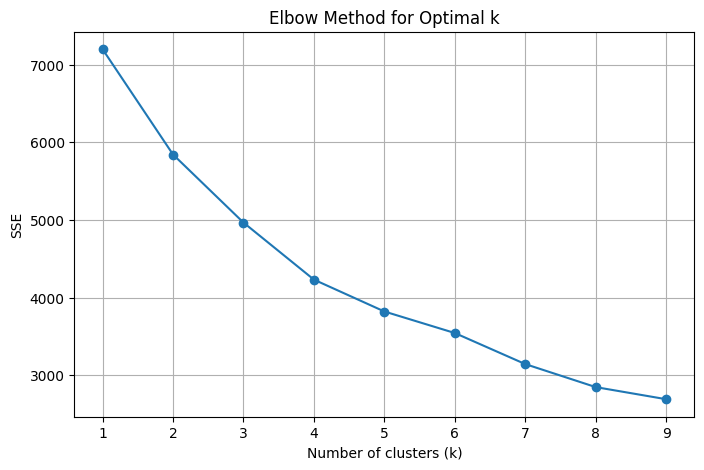

In [ ]:

# Plot the elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

In [ ]:
# Fit the model with k=4 (you can adjust based on elbow result)
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['segment'] = kmeans.fit_predict(X_scaled)


In [ ]:
segment_summary = customer_df.groupby('segment')[features].mean().round(2)
segment_summary


,total_orders,total_spend,avg_spend,avg_rating,avg_prep_time,avg_delivery_time,weekend_order_pct
segment,,,,,,,
0,1.30,31.48,24.97,4.41,27.43,24.39,0.0
1,1.30,16.13,12.44,4.44,23.83,23.93,0.0
2,3.96,68.34,17.31,4.37,27.16,24.25,0.0
3,1.22,15.51,12.69,4.21,31.38,24.32,0.0


In [ ]:
customer_df.to_csv('customer_segments.csv', index=False)


/tmp/ipython-input-22-1101000334.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customer_df, x='segment', palette='Set2')


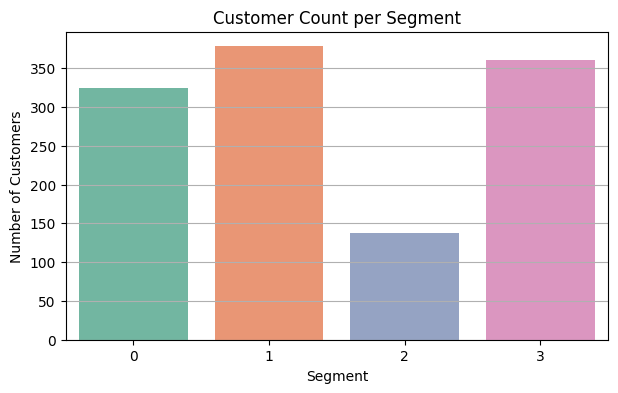

In [ ]:
# 1. Count of Customers per Segment Visual
plt.figure(figsize=(7, 4))
sns.countplot(data=customer_df, x='segment', palette='Set2')
plt.title('Customer Count per Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.grid(axis='y')
plt.savefig('segment-count.png', bbox_inches='tight')
plt.show()


/tmp/ipython-input-23-3757109224.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=customer_df, x='segment', y='avg_spend', palette='coolwarm')


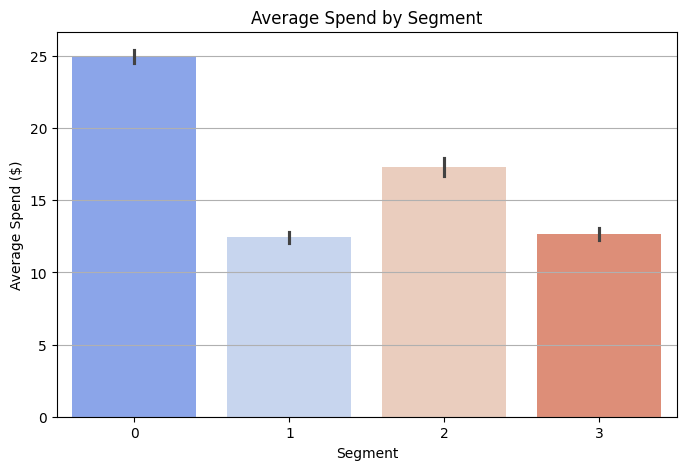

In [ ]:
# 💰 2. Average Spend by Segment
plt.figure(figsize=(8, 5))
sns.barplot(data=customer_df, x='segment', y='avg_spend', palette='coolwarm')
plt.title('Average Spend by Segment')
plt.xlabel('Segment')
plt.ylabel('Average Spend ($)')
plt.grid(axis='y')
plt.savefig('average_spend.png', bbox_inches='tight')
plt.show()


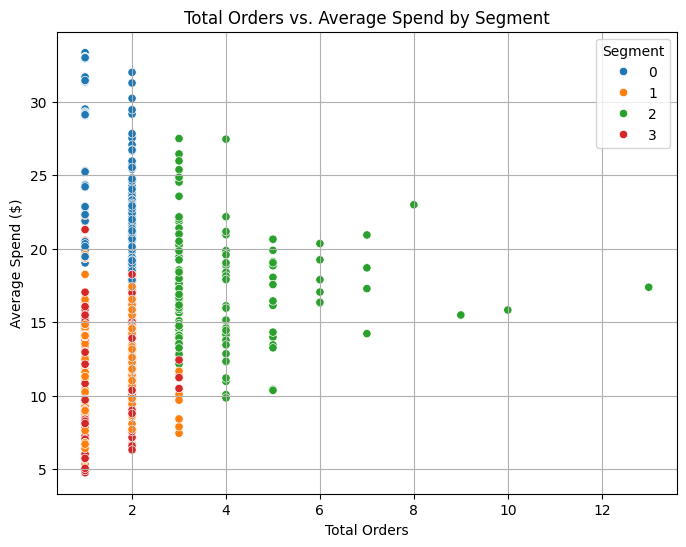

In [ ]:
# 🍽️ 3. Total Orders vs. Average Spend
# This shows frequency vs. value.
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_df, x='total_orders', y='avg_spend', hue='segment', palette='tab10')
plt.title('Total Orders vs. Average Spend by Segment')
plt.xlabel('Total Orders')
plt.ylabel('Average Spend ($)')
plt.legend(title='Segment')
plt.grid(True)
plt.savefig('orders_vs_avg_spend.png', bbox_inches='tight')
plt.show()


/tmp/ipython-input-25-3287492086.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_df, x='segment', y='avg_delivery_time', palette='Set3')


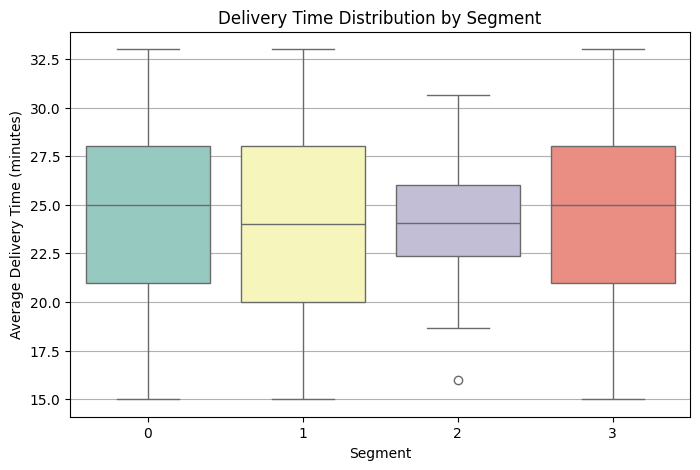

In [ ]:
# ⏱️ 4. Average Delivery Time by Segment
plt.figure(figsize=(8, 5))
sns.boxplot(data=customer_df, x='segment', y='avg_delivery_time', palette='Set3')
plt.title('Delivery Time Distribution by Segment')
plt.xlabel('Segment')
plt.ylabel('Average Delivery Time (minutes)')
plt.grid(axis='y')
plt.savefig('avg_del_time.png', bbox_inches='tight')
plt.show()


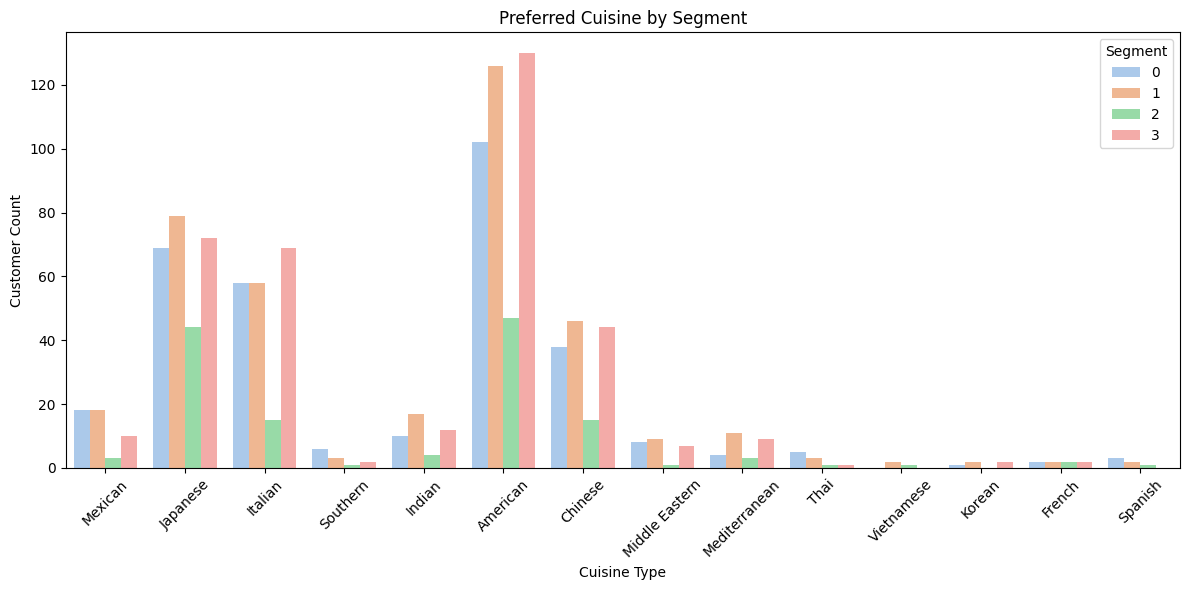

In [ ]:
# 5. Top Cuisine Breakdown
plt.figure(figsize=(12, 6))
sns.countplot(data=customer_df, x='top_cuisine', hue='segment', palette='pastel')
plt.title('Preferred Cuisine by Segment')
plt.xlabel('Cuisine Type')
plt.ylabel('Customer Count')
plt.xticks(rotation=45)
plt.legend(title='Segment')
plt.tight_layout()
plt.savefig('top_cuisine.png', bbox_inches='tight')
plt.show()


In [ ]:
# Download Visualizations
files.download('segment-count.png')
files.download('average_spend.png')
files.download('orders_vs_avg_spend.png')
files.download('avg_del_time.png')
files.download('top_cuisine.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>